### Step 1
Analyse the data in the raw dataset answering the following questions (note, you are free to choose the suitable methods ofthe analysis yourself, based on your knowledge of e.g. applied statistics or other courses of your study)

In [ ]:
import pandas as pd
from scipy.stats import chisquare
import numpy as np 
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# reading in the data

survey_data = pd.read_excel("data/private_dataE.xlsx")
results_data = pd.read_excel("data/public_data_resultsE.xlsx")
pub_data_register = pd.read_excel('data/public_data_registerE.xlsx')

#### Data cleanup

In [3]:
# naming the unnamed column to "where voting" as it refers to polling stations and evotes
results_data = results_data.rename(columns = {"Unnamed: 0":"where_voting"})

# creating a transformed version of the results data for evotes vs polling stations
def rename(x): 
    if "Polling station" in x: 
        return "Polling station"
    else: 
        return "E-votes"
transformed_results_data = results_data.copy()
transformed_results_data["where_voting"]= transformed_results_data["where_voting"].apply(lambda x: rename(x))
agg_functions = {'Red': 'sum','Green': 'sum', 'Invalid ballots': 'sum' ,'Total': 'sum'  }
df_new = transformed_results_data.groupby(transformed_results_data["where_voting"]).aggregate(agg_functions).reset_index()

### (A) 

Is there a significant difference between the political preferences as expressed in the survey and the election results for bothelectronic and polling station votes?

In [4]:
# Count votes by political preference within each voting type
preference_counts = survey_data.groupby(["evote", "party"]).size().unstack(fill_value=0).reset_index()
preference_counts["total"]= preference_counts[['Green', 'Red', "Invalid vote"]].sum(axis=1)
# Calculate proportions for each political preference within each voting type
preference_counts["prop_green"]=preference_counts["Green"]/preference_counts["total"]
preference_counts["prop_red"]=preference_counts["Red"]/preference_counts["total"]
preference_counts["prop_inv"]=preference_counts["Invalid vote"]/preference_counts["total"]
preference_counts.head()

party,evote,Green,Invalid vote,Red,total,prop_green,prop_red,prop_inv
0,0,88,3,47,138,0.637681,0.340580,0.021739
1,1,43,0,19,62,0.693548,0.306452,0.000000


In [5]:
# Calculating proportions for political preferences in the public results data
df_new["prop_green"]=df_new["Green"]/df_new["Total"]
df_new["prop_red"]=df_new["Red"]/df_new["Total"]
df_new["prop_inv"]=df_new["Invalid ballots"]/df_new["Total"]
df_new.head()

,where_voting,Red,Green,Invalid ballots,Total,prop_green,prop_red,prop_inv
0,E-votes,489,913,28,1430,0.638462,0.341958,0.019580
1,Polling station,273,475,12,760,0.625000,0.359211,0.015789


In [32]:
survey_data

,name,sex,evote,dob,zip,education,citizenship,marital_status,party
0,"Morris, Emily",Female,0,1977-12-19,2400,Vocational bachelors educations,Denmark,Never married,Red
1,"Freda, Michael",Male,1,1986-12-01,2200,Masters programmes,Denmark,Married/separated,Green
2,"Goosby, Emil",Male,1,1997-08-10,2200,Vocational bachelors educations,Denmark,Never married,Green
3,"Alcantar, Amanda",Female,0,1965-01-18,2200,Vocational Education and Training (VET),Denmark,Divorced,Green
4,"Havick, Justin",Male,0,1958-10-13,2200,Vocational Education and Training (VET),Denmark,Divorced,Green
...,...,...,...,...,...,...,...,...,...
195,"Weaver, Sabrina",Female,0,1960-10-12,2200,Vocational Education and Training (VET),Denmark,Married/separated,Green
196,"el-Fawaz, Imtinaan",Female,0,1961-10-28,2400,Vocational Education and Training (VET),Denmark,Married/separated,Green
197,"Marquez, Nickolas",Male,1,1997-06-08,2300,Primary education,Denmark,Never married,Green
198,"Montoya, Avona",Female,0,2001-06-10,2200,Primary education,Stateless,Never married,Green


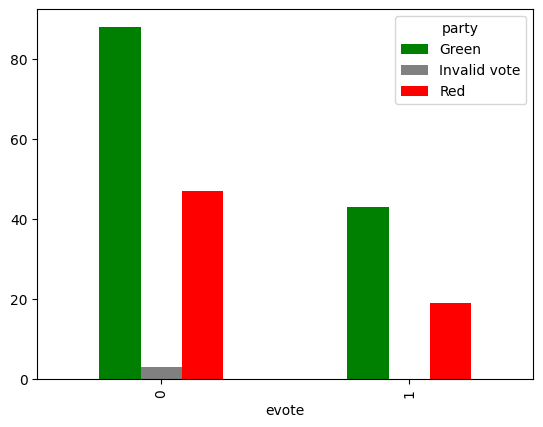

In [ ]:
# Define a color list for each party
party_colors = ["green", "gray", "red"]

# Plot the survey data
plot_data = survey_data.groupby(["evote", "party"]).size().unstack().plot(kind='bar',color=party_colors)


<Axes: xlabel='where_voting'>

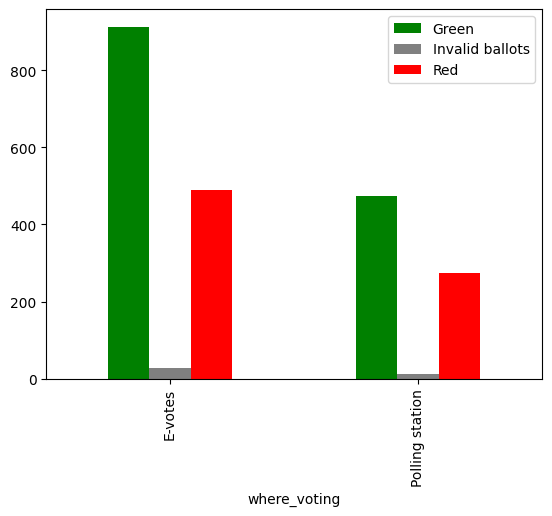

In [ ]:
# Plot the results data
df_new.plot(
    kind='bar', 
    x='where_voting', 
    y=['Green', 'Invalid ballots', 'Red'], 
    color=party_colors,
)

#### Two sample proportion z-test

In [90]:
result_green_polling = df_new.loc[df_new['where_voting'] == 'Polling station', 'Green'].iloc[0]
result_total_polling = df_new.loc[df_new['where_voting'] == 'Polling station', 'Total'].iloc[0]
survey_green_polling = preference_counts.loc[preference_counts['evote'] == 0, 'Green'].iloc[0]
survey_total_polling = preference_counts.loc[preference_counts['evote'] == 0, 'total'].iloc[0]


result_green_evotes = df_new.loc[df_new['where_voting'] == 'E-votes', 'Green'].iloc[0]
result_total_evotes = df_new.loc[df_new['where_voting'] == 'E-votes', 'Total'].iloc[0]
survey_green_evotes = preference_counts.loc[preference_counts['evote'] == 1, 'Green'].iloc[0]
survey_total_evotes = preference_counts.loc[preference_counts['evote'] == 1, 'total'].iloc[0]

print(result_green_evotes, result_total_evotes, survey_green_evotes, survey_total_evotes)


913 1430 43 62


In [103]:
def two_sample_z_test(dataset_1_part, dataset_1_total, dataset_2_part, dataset_2_total):
    z_score, p_value = proportions_ztest(
        [dataset_1_part, dataset_2_part], [dataset_1_total, dataset_2_total ], alternative='two-sided')
    significance = ""
    if p_value < 0.05:
        significance = "Yes."
    else:
        significance = "No."

    print("Z-score:", z_score)
    print("P-value:", p_value)
    print("Is it statistically significant? ",significance)

In [104]:
two_sample_z_test(result_green_polling, result_total_polling, survey_green_polling,survey_total_polling )

Z-score: -0.28337848165736645
P-value: 0.7768867217758352
Is it statistically significant?  No.


In [ ]:
# z-test for polling station 
z_score_p, p_value_p = proportions_ztest([475, 88], [760, 138], alternative='two-sided')

print("Z-score:", z_score_p)
print("P-value:", p_value_p)
print(p_value_p < 0.05)

Z-score: -0.28337848165736645
P-value: 0.7768867217758352
False


In [13]:
# z-test for evotes 
z_score_e, p_value_e = proportions_ztest([913, 43], [1430, 62], alternative='two-sided')

print("Z-score:", z_score_e)
print("P-value:", p_value_e)
print(p_value_e < 0.05)

Z-score: -0.8850847590713444
P-value: 0.37611091887805415
False


#### Chi-squared test

In [ ]:
e_votes_r = np.array(df_new[df_new["where_voting"]=="E-votes"][["Red","Green", "Invalid ballots"]]/1430).tolist()[0]
p_votes_r = np.array(df_new[df_new["where_voting"]=="Polling station"][["Red","Green", "Invalid ballots"]]).tolist()[0]

e_votes_s = np.array(preference_counts[preference_counts["evote"]==1][["Red","Green", "Invalid vote"]]/62).tolist()[0]
p_votes_s = np.array(preference_counts[preference_counts["evote"]==0][["Red","Green", "Invalid vote"]]).tolist()[0]

# chi square test for evotes 
chisquare(f_obs=e_votes_s, f_exp=e_votes_r)
# data = pd.DataFrame({
#     "Evotes_results": e_votes_r,
#     "Evotes_survey": e_votes_s
# })

Power_divergenceResult(statistic=0.02802007491159843, pvalue=0.9860876464020224)

### (B) 

Is there a significant difference between political preferences of the voters depending on their demographic attributes recorded inthe survey (that is, age, gender, education level...)?

In [105]:
contingency_table_gender = pd.crosstab(survey_data['sex'], survey_data['party'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table_gender)
print("Chi-square Test Results for Gender vs Political Preference")
print("Chi-square statistic:", chi2)
print("p-value:", p_value)

contingency_table_education = pd.crosstab(survey_data['education'], survey_data['party'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table_education)
print("\nChi-square Test Results for Education vs Political Preference")
print("Chi-square statistic:", chi2)
print("p-value:", p_value)

#transform date of birth to age
survey_data['age'] = 2024 - survey_data['dob'].dt.year
contingency_table_age = pd.crosstab(survey_data['age'], survey_data['party'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table_age)
print("\nChi-square Test Results for Age vs Political Preference")
print("Chi-square statistic:", chi2)
print("p-value:", p_value)


Chi-square Test Results for Gender vs Political Preference
Chi-square statistic: 1.0948595723439902
p-value: 0.578434602059867

Chi-square Test Results for Education vs Political Preference
Chi-square statistic: 34.70051433812302
p-value: 0.0043666219362705665

Chi-square Test Results for Age vs Political Preference
Chi-square statistic: 130.03690118193933
p-value: 0.5806961048843412


In [115]:
def chi2(data_attribute, data_preference):
    contingency_table = pd.crosstab(data_attribute, data_preference)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square Test Results for {data_attribute.name} vs {data_preference.name}")
    print("Chi-square statistic:", chi2)
    print("p-value:", p_value)

chi2(survey_data['sex'], survey_data['party'])

Chi-square Test Results for sex vs party
Chi-square statistic: 1.0948595723439902
p-value: 0.578434602059867


### (C) 

Is there a significant difference between voter’s choice of the voting channel (that is, if they decide to vote either online or inperson) depending on their demographic attributes recorded in the survey?

In [19]:

# Example: Chi-square test for voting channel by gender
contingency_table_channel_gender = pd.crosstab(survey_data['sex'], survey_data['evote'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table_channel_gender)
print("Chi-square Test Results for Gender vs Voting Channel")
print("Chi-square statistic:", chi2)
print("p-value:", p_value)

contingency_table_channel_education = pd.crosstab(survey_data['education'], survey_data['evote'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table_channel_education)
print("\nChi-square Test Results for Education vs Voting Channel")
print("Chi-square statistic:", chi2)
print("p-value:", p_value)

contingency_table_channel_age = pd.crosstab(survey_data['age'], survey_data['evote'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table_channel_age)
print("\nChi-square Test Results for Age vs Voting Channel")
print("Chi-square statistic:", chi2)
print("p-value:", p_value)

Chi-square Test Results for Gender vs Voting Channel
Chi-square statistic: 2.6379263431645796
p-value: 0.10433965288985117

Chi-square Test Results for Education vs Voting Channel
Chi-square statistic: 8.784052225187445
p-value: 0.36083942749998765

Chi-square Test Results for Age vs Voting Channel
Chi-square statistic: 63.97738150893831
p-value: 0.5821109942082197
